# Distribution analysis, whitening

## Preparations

In [230]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate
from pathlib import Path
from tqdm import tqdm
from itertools import chain
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import svdvals
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 90

In [231]:
if not Path('/content/embeddings/').exists():
    ! git clone https://github.com/Reason239/multimodal-embeddings-analysis.git
    ! cp -a /content/multimodal-embeddings-analysis/. /content/
    ! rm -rf /content/multimodal-embeddings-analysis
    # Gdrive fails sometimes
    # ! mkdir -p /content/embeddings/
    # # ~1 Gb download
    # ! gdown https://drive.google.com/drive/folders/1DnyubYHyKRI5Xm_LArzI5Si7rKzoyGU-?usp=sharing -O /content/ --folder

In [232]:
# if not Path('/content/embeddings/coco_val2014/image/CLIP_ViT-B-32.pt').exists():
#     ! mkdir -p /content/embeddings/coco_val2014/image/
#     ! gdown 1pUbP4ybpPlhtHQXloNdJvevwmoQw83ja -O /content/embeddings/coco_val2014/image/CLIP_ViT-B-32.pt
# if not Path('/content/embeddings/coco_val2014/text/CLIP_ViT-B-32_0.pt').exists():
#     ! mkdir -p /content/embeddings/coco_val2014/text/
#     ! gdown 1Zgl1QCK5y7UXzCwWz2CUU8CkrnuYgB6m -O /content/embeddings/coco_val2014/text/CLIP_ViT-B-32_0.pt

In [233]:
clip_filename = 'CLIP_ViT-B-32'
# clip_filename = 'CLIP_RN101'

In [234]:
image_embeddings = torch.load(f'/content/embeddings/coco_val2014/image/{clip_filename}.pt', map_location='cpu')
text_embeddings = torch.load(f'/content/embeddings/coco_val2014/text/{clip_filename}_0.pt', map_location='cpu')

In [235]:
def centered(embedding_matrix):
    return embedding_matrix - embedding_matrix.mean(0)

def normed(embedding_matrix):
    if isinstance(embedding_matrix, torch.Tensor):
        return embedding_matrix / embedding_matrix.norm(dim=-1, keepdim=True) 
    return embedding_matrix / np.linalg.norm(embedding_matrix, axis=-1, keepdims=True)

In [236]:
image_embeddings.shape, text_embeddings.shape

(torch.Size([40504, 512]), torch.Size([40504, 512]))

In [237]:
n = 4
im_e = normed(image_embeddings[:n])
te_e = normed(text_embeddings[:n])
im_e @ te_e.T

tensor([[0.2759, 0.1660, 0.2350, 0.1979],
        [0.1865, 0.2782, 0.1536, 0.1121],
        [0.1721, 0.2019, 0.2860, 0.1182],
        [0.2452, 0.1275, 0.1400, 0.3198]])

Isotropy measures

$I_1, I_2$ metrics, coordinates std plots

In [239]:
def get_eigen_vectors(input):
    return torch.real(torch.eig(input, eigenvectors=True)[1])

def Z(matrix, vector):
    return torch.exp((matrix * vector).sum(dim=1)).sum()

def get_isotropy_1(embeddings):
    eigen_vectors = get_eigen_vectors(torch.transpose(embeddings, 0, 1) @ embeddings)

    min_z = Z(embeddings, eigen_vectors[0])
    max_z = min_z
    for eigen_vector in eigen_vectors[1:]:
        z = Z(embeddings, eigen_vector)
        min_z = z if z < min_z else min_z
        max_z = z if z > max_z else max_z
    return float((min_z / max_z).numpy())

def get_isotropy_2(embeddings):
    eigen_vectors = get_eigen_vectors(torch.transpose(embeddings, 0, 1) @ embeddings)

    all_z = []
    for eigen_vector in eigen_vectors:
        all_z.append(float(Z(embeddings, eigen_vector).numpy()))
    variance = np.var(all_z)
    mean = np.mean(all_z)
    return np.sqrt(variance / mean ** 2)

def plot_std_dims_distribution(embeddings, label):
    std_dims = torch.std(embeddings, dim=0)
    # sns.distplot(std_dims, kde=False, norm_hist=True, label=label)
    plt.hist(std_dims, bins='rice', edgecolor='none', density=True, alpha=0.5, label=label)

In [240]:
get_isotropy_1(normed(torch.randn(1000, 10))), get_isotropy_1(normed(torch.rand(1000, 10)) + 1)

(0.9767308831214905, 0.011764923110604286)

In [241]:
get_isotropy_2(normed(torch.randn(1000, 10))), get_isotropy_2(normed(torch.rand(1000, 10)) + 1)

(0.011949351512876709, 1.1550726143664114)

Visualization using first 2 SVD components

In [242]:
def embedding_visualisation(embedding_matrix, centering=False, divide=False):
    if centering:
        embedding_matrix = centered(embedding_matrix)
    svd = TruncatedSVD(n_components=2)
    svd.fit(embedding_matrix)
    comp_tr = np.transpose(svd.components_)
    proj = np.dot(embedding_matrix, comp_tr)

    svs = svdvals(embedding_matrix)
    svs /= svs.max()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    if not divide:
        plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.1)
    else:
        half = embedding_matrix.shape[0] // 2
        plt.scatter(proj[:half, 0], proj[:half, 1], s=1, alpha=0.1, label='image')
        plt.scatter(proj[half:, 0], proj[half:, 1], s=1, alpha=0.1, label='text')
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    plt.scatter([0], [0], c='r', marker='+', s=100)
    plt.axis('scaled')
    plt.xlabel('SVD component 1')
    plt.ylabel('SVD component 2')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(svs)), svs)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Index')
    plt.ylabel('Normalized Singular Value')

    return proj, svs

Whitening

In [243]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
if not Path('whitening.py').exists():
    ! wget https://raw.githubusercontent.com/Reason239/multimodal-embeddings-analysis/main/whitening.py

In [245]:
from whitening import Whitener

In [246]:
@torch.no_grad()
def whiten_embeddings(embedding_matrix, k=2):
    embedding_matrix = torch.FloatTensor(embedding_matrix)
    whitener = Whitener(embedding_matrix.shape[1], k)
    whitener.compute_parameters(embedding_matrix)
    return whitener(embedding_matrix)

In [247]:
whitening_k = 128

## Norms and cosine similarities distributions

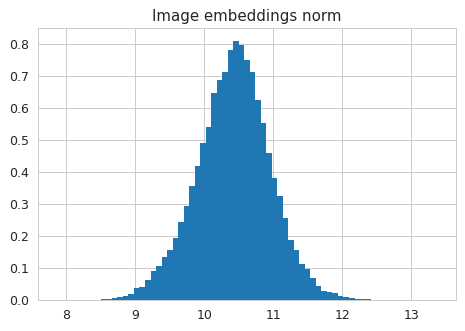

In [248]:
plt.hist(image_embeddings.norm(dim=-1).cpu(), bins='rice', edgecolor='none', density=True)
plt.title('Image embeddings norm')
plt.show()

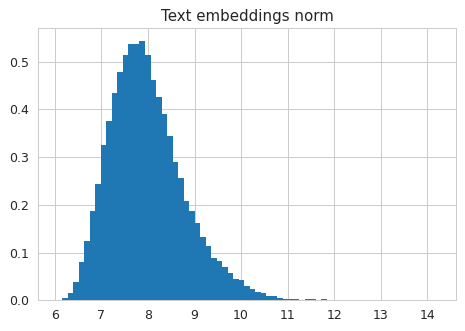

In [249]:
plt.hist(text_embeddings.norm(dim=-1).cpu(), bins='rice', edgecolor='none', density=True)
plt.title('Text embeddings norm')
plt.show()

CLIP uses cosine similarity, so norms have no meaning, so we normalize the embeddings

In [250]:
image_embeddings = normed(image_embeddings)
text_embeddings = normed(text_embeddings)
image_embeddings_np = image_embeddings.cpu().numpy()
text_embeddings_np = text_embeddings.cpu().numpy()

In [251]:
image_batch = image_embeddings[:1024]
text_batch = text_embeddings[:1024]

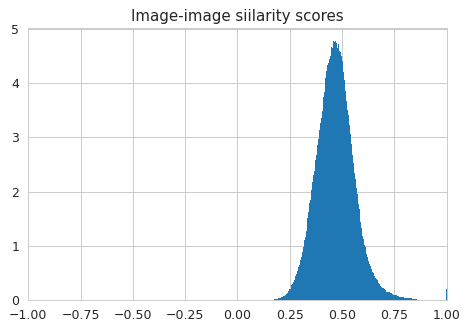

In [252]:
plt.hist((image_batch @ image_batch.T).cpu().reshape(-1), bins='rice', edgecolor='none', density=True)
plt.xlim(-1, 1)
plt.title('Image-image siilarity scores')
plt.show()

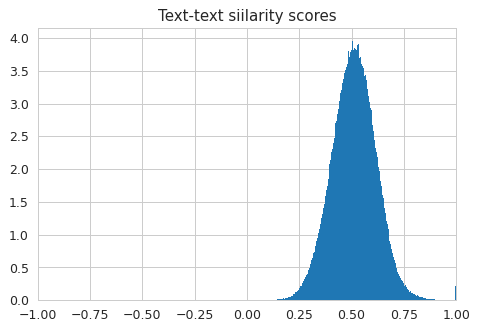

In [253]:
plt.hist((text_batch @ text_batch.T).cpu().reshape(-1), bins='rice', edgecolor='none', density=True)
plt.xlim(-1, 1)
plt.title('Text-text siilarity scores')
plt.show()

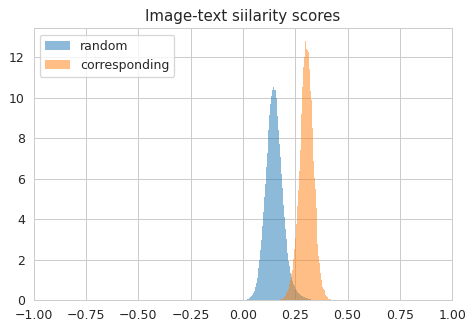

In [254]:
all_similarities = (image_batch @ text_batch.T).cpu().reshape(-1)
corresp_similarities = (image_embeddings * text_embeddings).sum(-1).cpu()
plt.hist(all_similarities, bins='rice', edgecolor='none', density=True, label='random', alpha=0.5)
plt.hist(corresp_similarities, bins='rice', edgecolor='none', density=True, label='corresponding', alpha=0.5)
plt.title('Image-text siilarity scores')
plt.xlim(-1, 1)
plt.legend(loc='upper left')
plt.show()

In [255]:
print(f'Gap between similarities: {corresp_similarities.mean() - all_similarities.mean()}')

Gap between similarities: 0.15297837555408478


In [256]:
image_batch_centered = centered(image_batch)
image_batch_centered_normed = normed(image_batch_centered)

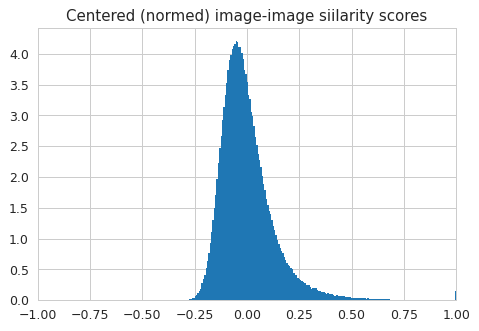

Mean cosine similarity: 0.00013426621444523335


In [257]:
scores = (image_batch_centered_normed @ image_batch_centered_normed.T).cpu().reshape(-1)
plt.hist(scores, bins='rice', edgecolor='none', density=True)
plt.xlim(-1, 1)
plt.title('Centered (normed) image-image siilarity scores')
plt.show()
print(f'Mean cosine similarity: {scores.mean()}')

## Image and text embeddings distributions

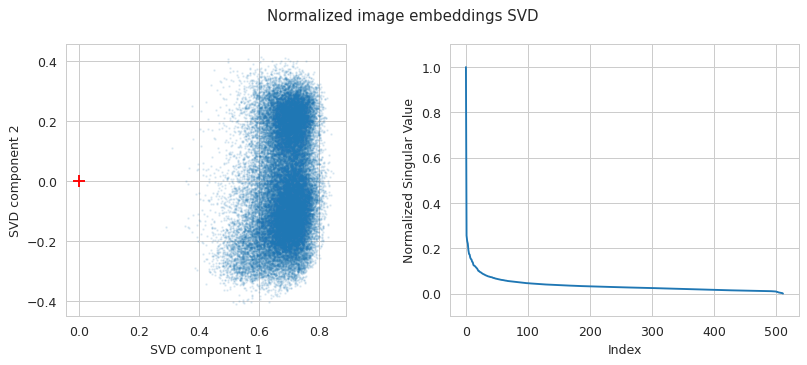

I_1 metric: 0.83
I_2 metric: 0.03


In [258]:
name = 'Normalized image embeddings'
embedding_visualisation(image_embeddings_np)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(image_embeddings):.2f}')
print(f'I_2 metric: {get_isotropy_2(image_embeddings):.2f}')

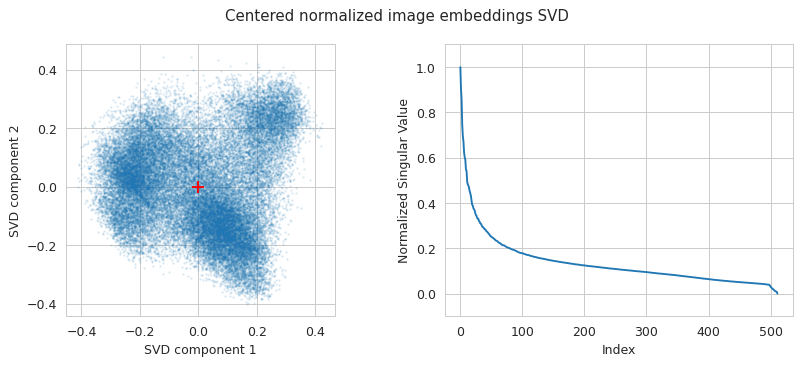

I_1 metric: 1.00
I_2 metric: 0.00


In [259]:
name = 'Centered normalized image embeddings'
embedding_visualisation(image_embeddings_np, centering=True)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(centered(image_embeddings))):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(centered(image_embeddings))):.2f}')

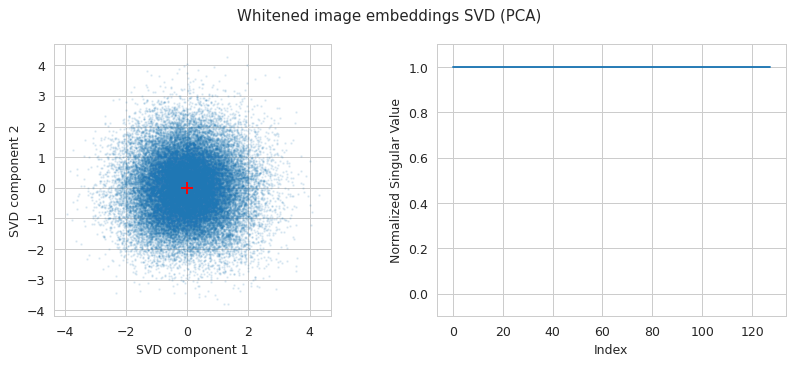

I_1 metric: 1.00
I_2 metric: 0.00


In [260]:
name = 'Whitened image embeddings'
image_embeddings_whitened = whiten_embeddings(image_embeddings_np, whitening_k)
proj, svs = embedding_visualisation(image_embeddings_whitened)
plt.suptitle(f'{name} SVD (PCA)')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(image_embeddings_whitened)):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(image_embeddings_whitened)):.2f}')

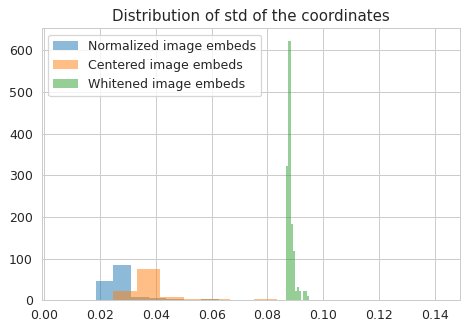

In [261]:
plot_std_dims_distribution(normed(image_embeddings), 'Normalized image embeds')
plot_std_dims_distribution(normed(centered(image_embeddings)), 'Centered image embeds')
plot_std_dims_distribution(normed(image_embeddings_whitened), 'Whitened image embeds')
plt.legend()
plt.title('Distribution of std of the coordinates')
plt.show()

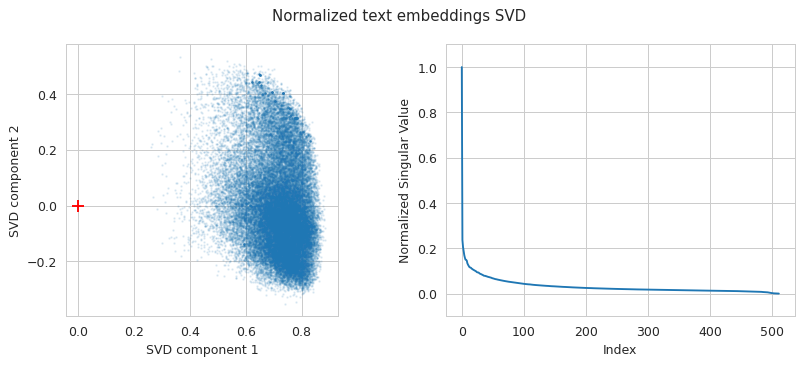

I_1 metric: 0.84
I_2 metric: 0.03


In [262]:
name = 'Normalized text embeddings'
embedding_visualisation(text_embeddings_np)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(text_embeddings):.2f}')
print(f'I_2 metric: {get_isotropy_2(text_embeddings):.2f}')

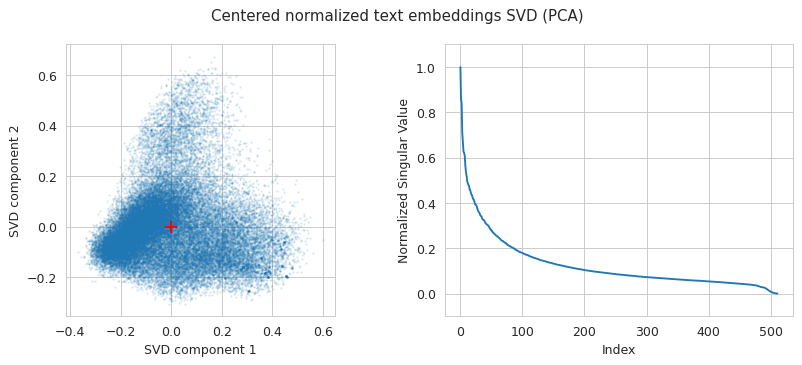

I_1 metric: 0.99
I_2 metric: 0.00


In [263]:
name = 'Centered normalized text embeddings'
embedding_visualisation(text_embeddings_np, centering=True)
plt.suptitle(f'{name} SVD (PCA)')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(centered(text_embeddings))):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(centered(text_embeddings))):.2f}')

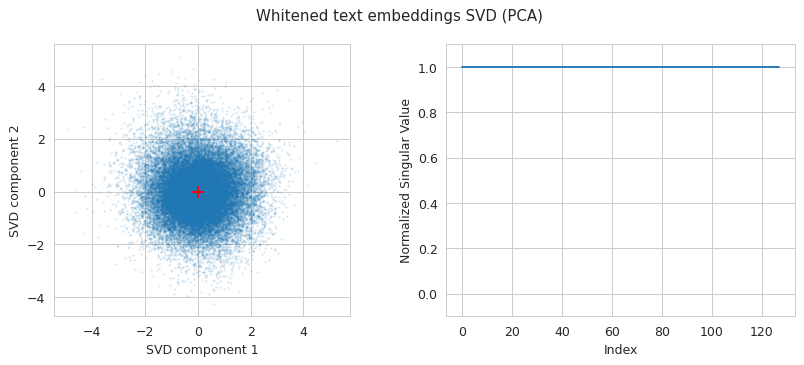

I_1 metric: 0.99
I_2 metric: 0.00


In [264]:
name = 'Whitened text embeddings'
text_embeddings_whitened = whiten_embeddings(text_embeddings_np, whitening_k)
proj, svs = embedding_visualisation(text_embeddings_whitened)
plt.suptitle(f'{name} SVD (PCA)')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(text_embeddings_whitened)):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(text_embeddings_whitened)):.2f}')

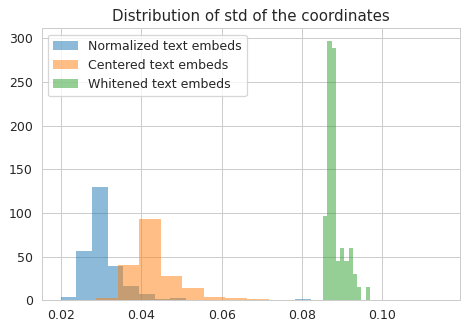

In [265]:
plot_std_dims_distribution(normed(text_embeddings), 'Normalized text embeds')
plot_std_dims_distribution(normed(centered(text_embeddings)), 'Centered text embeds')
plot_std_dims_distribution(normed(text_embeddings_whitened), 'Whitened text embeds')
plt.legend()
plt.title('Distribution of std of the coordinates')
plt.show()

## Image and text embeddings together

In [266]:
embedding_dim = image_embeddings.shape[1]
all_embeddings = torch.cat((image_embeddings, text_embeddings), dim=0)
image_whitener = Whitener(embedding_dim, k=20)
image_whitener.compute_parameters(image_embeddings)
text_whitener = Whitener(embedding_dim, k=20)
text_whitener.compute_parameters(text_embeddings)
joint_whitener = Whitener(embedding_dim, k=20)
joint_whitener.compute_parameters(all_embeddings)

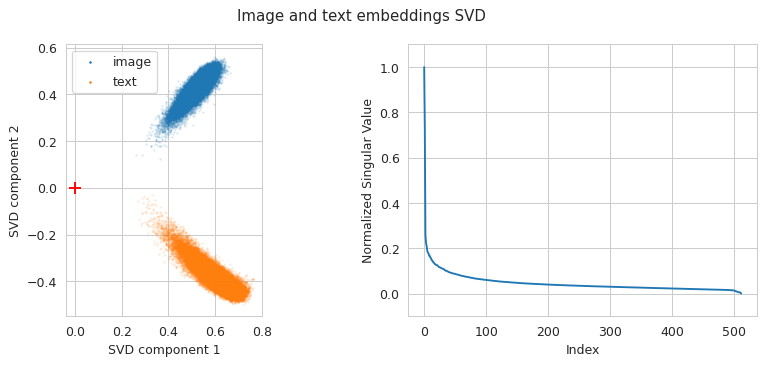

I_1 metric: 0.87
I_2 metric: 0.02


In [267]:
name = 'Image and text embeddings'
proj, svs = embedding_visualisation(all_embeddings, divide=True)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(all_embeddings):.2f}')
print(f'I_2 metric: {get_isotropy_2(all_embeddings):.2f}')

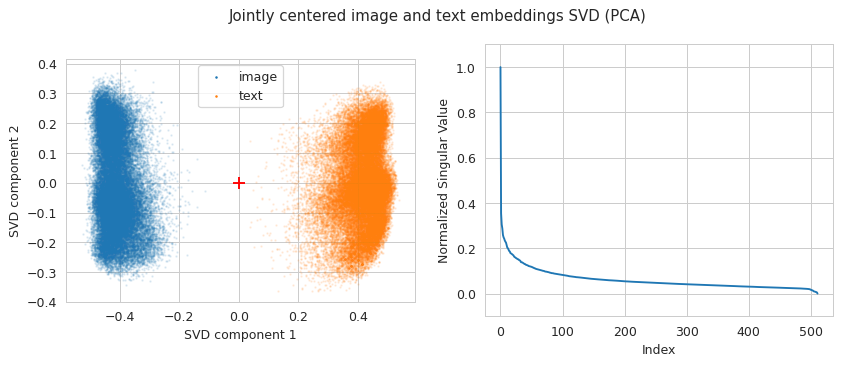

I_1 metric: 1.00
I_2 metric: 0.00


In [268]:
name = 'Jointly centered image and text embeddings'
proj, svs = embedding_visualisation(all_embeddings, centering=True, divide=True)
plt.suptitle(f'{name} SVD (PCA)')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(centered(all_embeddings))):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(centered(all_embeddings))):.2f}')

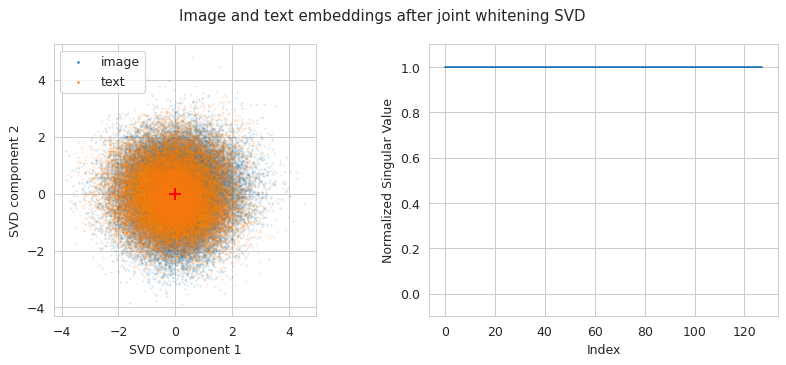

I_1 metric: 1.00
I_2 metric: 0.00


In [269]:
joint_whitener = Whitener(image_embeddings.shape[1], whitening_k)
joint_whitener.compute_parameters(all_embeddings)
all_embeddings_whitened = joint_whitener(all_embeddings)
name = 'Image and text embeddings after joint whitening'
proj, svs = embedding_visualisation(all_embeddings_whitened, divide=True)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(joint_whitener(all_embeddings))):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(joint_whitener(all_embeddings))):.2f}')

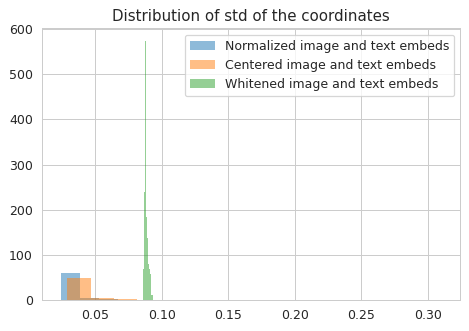

In [270]:
plot_std_dims_distribution(normed(all_embeddings), 'Normalized image and text embeds')
plot_std_dims_distribution(normed(centered(all_embeddings)), 'Centered image and text embeds')
plot_std_dims_distribution(normed(all_embeddings_whitened), 'Whitened image and text embeds')
plt.legend()
plt.title('Distribution of std of the coordinates')
plt.show()

# Orthogonal Procrustes to make images and texts closer

In [271]:
from scipy.linalg import orthogonal_procrustes

In [272]:
text_transform, _ = orthogonal_procrustes(text_embeddings_np, image_embeddings_np)

In [273]:
text_transformed = text_embeddings_np @ text_transform

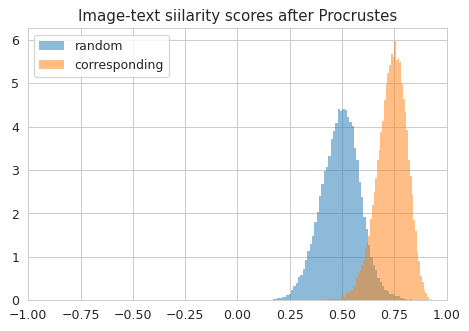

In [274]:
all_similarities = (image_batch @ text_transformed[:1024].T).cpu().reshape(-1)
corresp_similarities = (image_embeddings * text_transformed).sum(-1).cpu()
plt.hist(all_similarities[:len(corresp_similarities)], bins='rice', edgecolor='none', density=True, label='random', alpha=0.5)
plt.hist(corresp_similarities, bins='rice', edgecolor='none', density=True, label='corresponding', alpha=0.5)
plt.title('Image-text siilarity scores after Procrustes')
plt.xlim(-1, 1)
plt.legend(loc='upper left')
plt.show()

In [275]:
print(f'Gap between similarities: {corresp_similarities.mean() - all_similarities.mean()}')

Gap between similarities: 0.2482912242412567


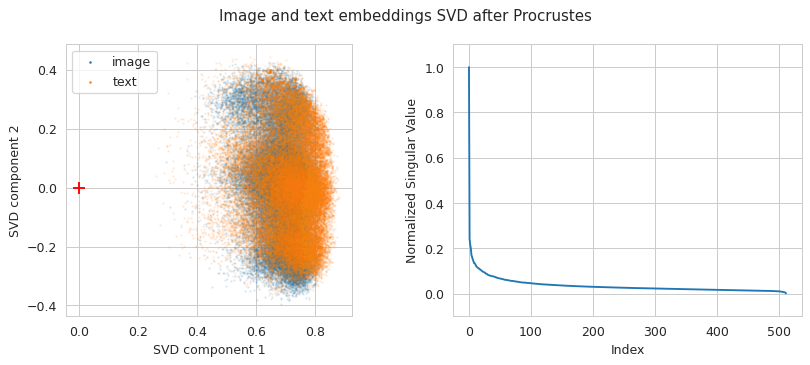

In [276]:
proj, svs = embedding_visualisation(torch.cat((image_embeddings, torch.from_numpy(text_transformed)), dim=0), divide=True)
plt.suptitle('Image and text embeddings SVD after Procrustes')
plt.show()

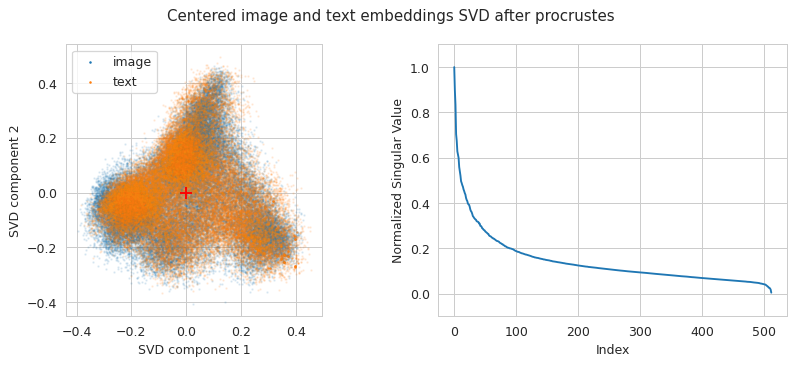

In [277]:
result = torch.cat((image_embeddings, torch.from_numpy(text_transformed)), dim=0)
proj, svs = embedding_visualisation(result, centering=True, divide=True)
plt.suptitle('Centered image and text embeddings SVD after procrustes')
plt.show()

In [278]:
text_transform_lstsq = torch.linalg.lstsq(text_embeddings, image_embeddings).solution
text_transformed_lstsq = text_embeddings @ text_transform_lstsq

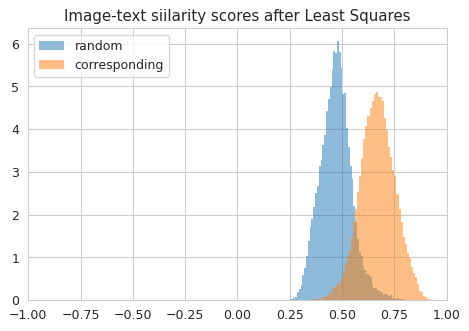

In [279]:
all_similarities = (image_batch @ text_transformed_lstsq[:1024].T).cpu().reshape(-1)
corresp_similarities = (image_embeddings * text_transformed_lstsq).sum(-1).cpu()
plt.hist(all_similarities[:len(corresp_similarities)], bins='rice', edgecolor='none', density=True, label='random', alpha=0.5)
plt.hist(corresp_similarities, bins='rice', edgecolor='none', density=True, label='corresponding', alpha=0.5)
plt.title('Image-text siilarity scores after Least Squares')
plt.xlim(-1, 1)
plt.legend(loc='upper left')
plt.show()

In [280]:
print(f'Gap between similarities: {corresp_similarities.mean() - all_similarities.mean()}')

Gap between similarities: 0.20164036750793457


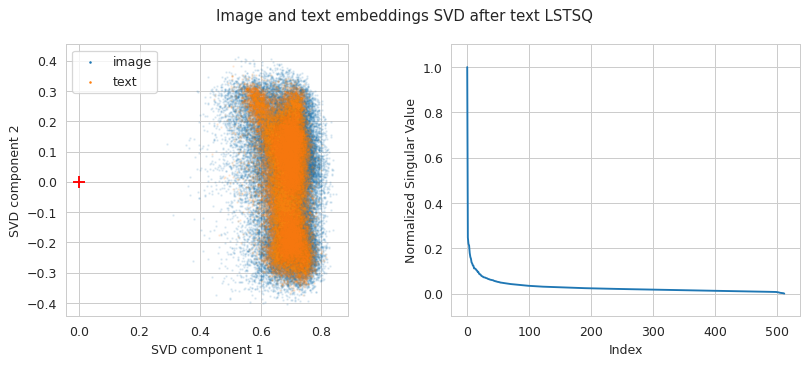

In [281]:
proj, svs = embedding_visualisation(torch.cat((image_embeddings, text_transformed_lstsq), dim=0), divide=True)
plt.suptitle('Image and text embeddings SVD after text LSTSQ')
plt.show()

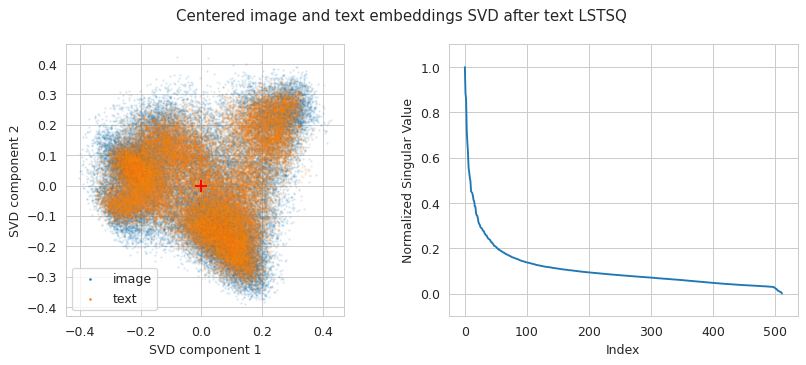

In [282]:
proj, svs = embedding_visualisation(torch.cat((image_embeddings, text_transformed_lstsq), dim=0), centering=True, divide=True)
plt.suptitle('Centered image and text embeddings SVD after text LSTSQ')
plt.show()

# CLIP loss after embeddings transformations

## Preparations

For CLIP loss we also need to know model's (learnable) logit_scale parameter

During CLIP training it's bounded by 100 and turns out that it learns to be 100 for all of the available models, I checked:

| Model name     | Logit scale        | Embedding dim |
|----------------|--------------------|------|
| RN50           | 100.00000762939453 | 1024 |
| RN101          | 100.00000762939453 | 512  |
| RN50x4         | 100.00000762939453 | 640  |
| RN50x16        | 100.00000762939453 | 768  |
| RN50x64        | 100.00000762939453 | 1024 |
| ViT-B/32       | 100.00000762939453 | 512  |
| ViT-B/16       | 100.00000762939453 | 512  |
| ViT-L/14       | 100.00000762939453 | 768  |
| ViT-L/14@336px | 100.00000762939453 | 768  |

In [283]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [284]:
def clip_loss(logits):
    labels = torch.arange(logits.shape[0])
    loss1 = F.cross_entropy(logits, labels, reduction='mean')
    loss2 = F.cross_entropy(logits.T, labels, reduction='mean')
    return (loss1 + loss2) / 2

In [286]:
def logit_matrix(image_embeddings, text_embeddings, distance='dot'):
    if distance == 'dot':
        return image_embeddings @ text_embeddings.T
    elif distance == 'cosine':
        return normed(image_embeddings) @ normed(text_embeddings).T
    elif distance == 'dist':
        distances = torch.cdist(torch.unsqueeze(image_embeddings, 0),
                                torch.unsqueeze(text_embeddings, 0))[0]
        return 1 - distances**2 / 2

@torch.no_grad()
def evaluate_clip_loss(image_embeddings, text_embeddings, logit_scale=100, 
                       batch_size=64, distance='cosine', with_tqdm=False):
    image_emeddings = torch.FloatTensor(image_embeddings)
    text_embeddings = torch.FloatTensor(text_embeddings)
    dataset = TensorDataset(image_embeddings, text_embeddings)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    loss = 0
    generator = tqdm(dataloader) if with_tqdm else dataloader
    for image_batch, text_batch in generator:
        logits = logit_scale * logit_matrix(image_batch, text_batch, distance)
        loss += clip_loss(logits)
    return loss / len(dataloader)

def evaluate_clip_loss_on_splits(splits, **kwargs):
    """splits = [image_train, text_train, image_test, text_test]"""
    train_loss = evaluate_clip_loss(splits[0], splits[1], **kwargs)
    test_loss = evaluate_clip_loss(splits[2], splits[3], **kwargs)
    distance = kwargs.get('distance', 'cosine')
    print(f'Train {distance} loss: {train_loss:.4f}, test {distance} loss: {test_loss:.4f}')
    return train_loss, test_loss

In [287]:
def get_train_test_split(image_embeddings, text_embeddings, seed=0):
    dataset_size = image_embeddings.shape[0]
    train_size = round(dataset_size * 0.8)
    ordering = torch.randperm(dataset_size, generator=torch.manual_seed(seed))
    image_embeddings_train = image_embeddings[ordering[:train_size]]
    text_embeddings_train = text_embeddings[ordering[:train_size]]
    image_embeddings_test = image_embeddings[ordering[train_size:]]
    text_embeddings_test = text_embeddings[ordering[train_size:]]
    return image_embeddings_train, text_embeddings_train, \
           image_embeddings_test, text_embeddings_test

In [288]:
def transform_embeddings(splits, modes):
    """splits = [image_train, text_train, image_test, text_test]"""
    splits = splits.copy()
    embedding_dim = splits[0].shape[1]
    mode_sequence = [mode.strip() for mode in modes.split(',')]
    for mode in mode_sequence:
        if not mode:
            pass
        elif mode == 'normalization':
            splits = [normed(split) for split in splits]
        elif mode == 'joint centering':
            mean = (splits[0].mean(dim=0) + splits[1].mean(dim=0)) / 2
            splits = [split - mean for split in splits]
        elif mode.startswith('joint whitening'):
            k = int(mode.split()[-1])
            all_train = torch.cat(splits[:2], dim=0)
            whitener = Whitener(embedding_dim, k)
            whitener.compute_parameters(all_train)
            splits = [whitener(split) for split in splits]
        elif mode == 'procrustes':
            image_train_np = splits[0].cpu().numpy()
            text_train_np = splits[1].cpu().numpy()
            text_transform, _ = orthogonal_procrustes(text_train_np, image_train_np)
            text_transform = torch.from_numpy(text_transform).to(splits[1])
            splits[1] = splits[1] @ text_transform
            splits[3] = splits[3] @ text_transform
        elif mode == 'lstsq':
            text_transform = torch.linalg.lstsq(splits[1], splits[0]).solution
            splits[1] = splits[1] @ text_transform
            splits[3] = splits[3] @ text_transform
        else:
            raise ValueError(f'Unknown mode: {mode}')
    return splits

In [289]:
splits = list(get_train_test_split(normed(image_embeddings), normed(text_embeddings)))

In [290]:
print(f'Train size: {splits[0].shape[0]}, test size: {splits[3].shape[0]}')

Train size: 32403, test size: 8101


In [291]:
batch_size = 64 

## Experiments

Reference values: no transformations

In [292]:
modes = ''
transformed_splits = transform_embeddings(splits, modes=modes)
print(f'After the sequence of transformations [{modes}]:')
evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size);

After the sequence of transformations []:
Train cosine loss: 0.4183, test cosine loss: 0.4097


Simple centering

In [293]:
modes = 'joint centering'
transformed_splits = transform_embeddings(splits, modes=modes)
print(f'After the sequence of transformations [{modes}]:')
evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size);

After the sequence of transformations [joint centering]:
Train cosine loss: 1.6153, test cosine loss: 1.6201


Joint whitening, no centering

In [294]:
for k in [2**p for p in range(10)]:
    modes = f'joint whitening {k}'
    transformed_splits = transform_embeddings(splits, modes=modes)
    print(f'After the sequence of transformations [{modes}]:')
    evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size, distance='cosine')
    # evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size, distance='dist')

After the sequence of transformations [joint whitening 1]:
Train cosine loss: 4.1565, test cosine loss: 4.1546
After the sequence of transformations [joint whitening 2]:
Train cosine loss: 45.6336, test cosine loss: 45.1404
After the sequence of transformations [joint whitening 4]:
Train cosine loss: 23.0519, test cosine loss: 23.2634
After the sequence of transformations [joint whitening 8]:
Train cosine loss: 16.4654, test cosine loss: 16.3464
After the sequence of transformations [joint whitening 16]:
Train cosine loss: 8.7996, test cosine loss: 8.7209
After the sequence of transformations [joint whitening 32]:
Train cosine loss: 3.6493, test cosine loss: 3.6026
After the sequence of transformations [joint whitening 64]:
Train cosine loss: 1.9358, test cosine loss: 1.9168
After the sequence of transformations [joint whitening 128]:
Train cosine loss: 1.5737, test cosine loss: 1.6042
After the sequence of transformations [joint whitening 256]:
Train cosine loss: 1.8763, test cosine l

Whitening after centering

In [295]:
for k in [2**p for p in range(10)]:
    modes = f'joint centering, joint whitening {k}'
    transformed_splits = transform_embeddings(splits, modes=modes)
    print(f'After the sequence of transformations [{modes}]:')
    evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size, distance='cosine')
    # evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size, distance='dist')

After the sequence of transformations [joint centering, joint whitening 1]:
Train cosine loss: 4.1565, test cosine loss: 4.1546
After the sequence of transformations [joint centering, joint whitening 2]:
Train cosine loss: 45.6336, test cosine loss: 45.1404
After the sequence of transformations [joint centering, joint whitening 4]:
Train cosine loss: 23.0519, test cosine loss: 23.2634
After the sequence of transformations [joint centering, joint whitening 8]:
Train cosine loss: 16.4654, test cosine loss: 16.3463
After the sequence of transformations [joint centering, joint whitening 16]:
Train cosine loss: 8.7996, test cosine loss: 8.7209
After the sequence of transformations [joint centering, joint whitening 32]:
Train cosine loss: 3.6493, test cosine loss: 3.6026
After the sequence of transformations [joint centering, joint whitening 64]:
Train cosine loss: 1.9358, test cosine loss: 1.9168
After the sequence of transformations [joint centering, joint whitening 128]:
Train cosine loss

Procrustes transformation

In [296]:
modes = 'procrustes'
transformed_splits = transform_embeddings(splits, modes=modes)
print(f'After the sequence of transformations [{modes}]:')
evaluate_clip_loss_on_splits(transformed_splits, batch_size=batch_size);

After the sequence of transformations [procrustes]:
Train cosine loss: 1.0223, test cosine loss: 1.2970


Least squares to fit the text closer to the images:

In [297]:
modes = 'lstsq'
transformed_splits_lstsq = transform_embeddings(splits, modes=modes)
print(f'After the sequence of transformations [{modes}]:')
evaluate_clip_loss_on_splits(transformed_splits_lstsq, batch_size=batch_size);

After the sequence of transformations [lstsq]:
Train cosine loss: 1.1785, test cosine loss: 1.3523


Again, although the loss increased, the gap between random image and text similarities and corresponding image and text similarities actually increased in terms of absolute value

In [298]:
all_mean = (splits[2] @ splits[3].T).mean()
corr_mean = ((splits[2] * splits[3]).sum(dim=-1)).mean()
print('Before procrustes:')
print(f'Mean similarity: {all_mean:.2f}, mean similarity of corresponding: {corr_mean:.2f}, gap: {corr_mean - all_mean:.2f}') 

all_mean = (transformed_splits[2] @ transformed_splits[3].T).mean()
corr_mean = ((transformed_splits[2] * transformed_splits[3]).sum(dim=-1)).mean()
print('After procrustes:')
print(f'Mean similarity: {all_mean:.2f}, mean similarity of corresponding: {corr_mean:.2f}, gap: {corr_mean - all_mean:.2f}') 

all_mean = (transformed_splits_lstsq[2] @ transformed_splits_lstsq[3].T).mean()
corr_mean = ((transformed_splits_lstsq[2] * transformed_splits_lstsq[3]).sum(dim=-1)).mean()
print('After least squares:')
print(f'Mean similarity: {all_mean:.2f}, mean similarity of corresponding: {corr_mean:.2f}, gap: {corr_mean - all_mean:.2f}') 

Before procrustes:
Mean similarity: 0.15, mean similarity of corresponding: 0.30, gap: 0.15
After procrustes:
Mean similarity: 0.49, mean similarity of corresponding: 0.73, gap: 0.24
After least squares:
Mean similarity: 0.47, mean similarity of corresponding: 0.67, gap: 0.20


# Evaluation on CIFAR-100

## Preparations

In [299]:
@torch.no_grad()
def evaluate_cifar_accuracy(image_embeddings, labels, text_embeddings, 
                            batch_size=64, distance='cosine', with_tqdm=False):
    image_emeddings = torch.FloatTensor(image_embeddings)
    labels = torch.LongTensor(labels)
    text_embeddings = torch.FloatTensor(text_embeddings)
    
    dataset = TensorDataset(image_embeddings, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    correct = 0
    total = 0
    generator = tqdm(dataloader) if with_tqdm else dataloader
    for image_batch, labels_batch in generator:
        scores = logit_matrix(image_batch, text_embeddings, distance)
        preds = torch.argmax(scores, dim=1)
        correct += (preds == labels_batch).sum().item()
        total += image_batch.shape[0]
    print(f'Accuracy is {correct / total:5.2%}')
    return correct / total

In [300]:
cifar_text_embeddings = torch.load(f'/content/embeddings/CIFAR100test/text/{clip_filename}.pt', map_location='cpu')
cifar_text_embeddings = normed(cifar_text_embeddings)

cifar_labels_test = torch.load(f'/content/embeddings/CIFAR100test/label/{clip_filename}.pt', map_location='cpu')
cifar_image_embeddings_test = torch.load(f'/content/embeddings/CIFAR100test/image/{clip_filename}.pt', map_location='cpu')
cifar_image_embeddings_test = normed(cifar_image_embeddings_test)
cifar_text_embeddings_test = cifar_text_embeddings[cifar_labels_test]

cifar_labels_train = torch.load(f'/content/embeddings/CIFAR100train/label/{clip_filename}.pt', map_location='cpu')
cifar_image_embeddings_train = torch.load(f'/content/embeddings/CIFAR100train/image/{clip_filename}.pt', map_location='cpu')
cifar_image_embeddings_train = normed(cifar_image_embeddings_train)
cifar_text_embeddings_train = cifar_text_embeddings[cifar_labels_train]

## Experiments

### Transforms described above

Just CLIP

In [301]:
evaluate_cifar_accuracy(cifar_image_embeddings_test, cifar_labels_test, cifar_text_embeddings, 
                        batch_size=64, distance='cosine');

Accuracy is 63.09%


Text embeddings rotated by the transform, found by Procrustes problem, learned on COCO

In [302]:
evaluate_cifar_accuracy(cifar_image_embeddings_test, cifar_labels_test, cifar_text_embeddings @ text_transform, 
                        batch_size=64, distance='cosine');

Accuracy is 38.42%


Text embeddings moved by the transform, found by Least Squares problem on COCO

In [303]:
evaluate_cifar_accuracy(cifar_image_embeddings_test, cifar_labels_test, cifar_text_embeddings @ text_transform_lstsq, 
                        batch_size=64, distance='cosine');

Accuracy is 39.21%


CIFAR test text embeddings rotated by the transform, found by Procrustes problem, learned on CIFAR train

In [304]:
text_transform_cifar, _ = orthogonal_procrustes(cifar_text_embeddings_train, 
                                                cifar_image_embeddings_train)
evaluate_cifar_accuracy(cifar_image_embeddings_test, cifar_labels_test, 
                        cifar_text_embeddings @ text_transform_cifar, 
                        batch_size=64, distance='cosine');

Accuracy is 61.39%


CIFAR test text embeddings rotated by the transform, found by Least Squares problem, learned on CIFAR train

In [305]:
text_transform_cifar_lstsq = torch.linalg.lstsq(cifar_text_embeddings_train, 
                                                cifar_image_embeddings_train).solution
evaluate_cifar_accuracy(cifar_image_embeddings_test, cifar_labels_test, 
                        cifar_text_embeddings @ text_transform_cifar_lstsq, 
                        batch_size=64, distance='cosine');

Accuracy is 65.53%


Text and Image embeddings after joint whitening, trained on COCO

In [306]:
evaluate_cifar_accuracy(joint_whitener(cifar_image_embeddings_test), 
                        cifar_labels_test, joint_whitener(cifar_text_embeddings), 
                        batch_size=64, distance='cosine');

Accuracy is 42.59%


CIFAR test image and text embeddings after whitening, learned on CIFAR train images

In [307]:
cifar_image_whitener = Whitener(cifar_image_embeddings_train.shape[1], whitening_k)
cifar_image_whitener.compute_parameters(cifar_image_embeddings_train)

evaluate_cifar_accuracy(cifar_image_whitener(cifar_image_embeddings_test), 
                        cifar_labels_test, cifar_image_whitener(cifar_text_embeddings), 
                        batch_size=64, distance='cosine');

Accuracy is 56.77%


### Domain adaptation / generalization

In [308]:
n_known_classes = 50
seed = 0
ordering = torch.randperm(100, generator=torch.manual_seed(seed))
known_classes = ordering[:n_known_classes]
new_classes = ordering[n_known_classes:]

train_known_inds = [i for i, label in enumerate(cifar_labels_train) if label in known_classes]
train_new_inds = [i for i, label in enumerate(cifar_labels_train) if label in new_classes]
test_known_inds = [i for i, label in enumerate(cifar_labels_test) if label in known_classes]
test_new_inds = [i for i, label in enumerate(cifar_labels_test) if label in new_classes]

cifar_image_embeddings_train_known = cifar_image_embeddings_train[train_known_inds]
cifar_image_embeddings_train_new = cifar_image_embeddings_train[train_new_inds]
cifar_image_embeddings_test_known = cifar_image_embeddings_test[test_known_inds]
cifar_image_embeddings_test_new = cifar_image_embeddings_test[test_new_inds]

cifar_labels_train_known = cifar_labels_train[train_known_inds]
cifar_labels_train_new = cifar_labels_train[train_new_inds]
cifar_labels_test_known = cifar_labels_test[test_known_inds]
cifar_labels_test_new = cifar_labels_test[test_new_inds]

cifar_text_embeddings_train_known = cifar_text_embeddings_train[train_known_inds]
cifar_text_embeddings_train_new = cifar_text_embeddings_train[train_new_inds]
cifar_text_embeddings_test_known = cifar_text_embeddings_test[test_known_inds]
cifar_text_embeddings_test_new = cifar_text_embeddings_test[test_new_inds]

In [309]:
print('On known classes on test, before transforms')
evaluate_cifar_accuracy(cifar_image_embeddings_test_known, 
                        cifar_labels_test_known, cifar_text_embeddings, 
                        batch_size=64, distance='cosine');
print('On new classes on test, before transforms')
evaluate_cifar_accuracy(cifar_image_embeddings_test_new, 
                        cifar_labels_test_new, cifar_text_embeddings, 
                        batch_size=64, distance='cosine');


On known classes on test, before transforms
Accuracy is 66.40%
On new classes on test, before transforms
Accuracy is 59.78%


In [310]:
text_tansform_known, _ = orthogonal_procrustes(cifar_text_embeddings_train_known, 
                                               cifar_image_embeddings_train_known)

print('On known classes on test after Procrustes')
evaluate_cifar_accuracy(cifar_image_embeddings_test_known, 
                        cifar_labels_test_known, cifar_text_embeddings @ text_tansform_known, 
                        batch_size=64, distance='cosine');
print('On new classes on test after Procrustes')
evaluate_cifar_accuracy(cifar_image_embeddings_test_new, 
                        cifar_labels_test_new, cifar_text_embeddings @ text_tansform_known, 
                        batch_size=64, distance='cosine');

On known classes on test after Procrustes
Accuracy is 70.88%
On new classes on test after Procrustes
Accuracy is 3.46%


In [311]:
text_tansform_known = text_transform_lstsq = torch.linalg.lstsq(cifar_text_embeddings_train_known, 
                                                                   cifar_image_embeddings_train_known).solution


print('On known classes on test after LSTSQ')
evaluate_cifar_accuracy(cifar_image_embeddings_test_known, 
                        cifar_labels_test_known, cifar_text_embeddings @ text_tansform_known, 
                        batch_size=64, distance='cosine');
print('On new classes on test after LSTSQ')
evaluate_cifar_accuracy(cifar_image_embeddings_test_new, 
                        cifar_labels_test_new, cifar_text_embeddings @ text_tansform_known, 
                        batch_size=64, distance='cosine');

On known classes on test after LSTSQ
Accuracy is 70.54%
On new classes on test after LSTSQ
Accuracy is 19.68%


### Dimensionality reduction

In [312]:
def svd_embeddings(embeddings, n_components=100):
    # Return linear 
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(embeddings)
    comp_tr = np.transpose(svd.components_)
    return comp_tr

In [313]:
# On image cifar 
for dist in ["dot", "cosine", "dist"]:
    svd_transform = svd_embeddings(cifar_image_embeddings_train, n_components=400)
    print(f"N_componenets {400}", f"Distance {dist}")
    print(evaluate_cifar_accuracy(cifar_image_embeddings_train @ svd_transform, 
                            cifar_labels_train, 
                            cifar_text_embeddings @ svd_transform, 
                            distance=dist,
                            batch_size=64, 
                            with_tqdm=False))

N_componenets 400 Distance dot
Accuracy is 63.59%
0.63588
N_componenets 400 Distance cosine
Accuracy is 42.85%
0.4285
N_componenets 400 Distance dist
Accuracy is 28.21%
0.28214


In [314]:
coco_embeddings = torch.cat([image_embeddings, text_embeddings], dim=0)
print(coco_embeddings.shape)

torch.Size([81008, 512])


In [315]:
# On image cifar 
basic_embeddings = coco_embeddings

for n_components in [300, 400, 500]:
    for dist in ["dot"]:
        svd_transform = svd_embeddings(basic_embeddings, n_components=n_components)
        print(f"N_componenets {n_components}", f"Distance {dist}")
        print(evaluate_cifar_accuracy(cifar_image_embeddings_train @ svd_transform, 
                                cifar_labels_train, 
                                cifar_text_embeddings @ svd_transform, 
                                distance=dist,
                                batch_size=64, 
                                with_tqdm=False))

N_componenets 300 Distance dot
Accuracy is 62.97%
0.62974
N_componenets 400 Distance dot
Accuracy is 63.82%
0.63818
N_componenets 500 Distance dot
Accuracy is 63.53%
0.63534


In [316]:
basic_embeddings = coco_embeddings

for n_components in [350, 375, 400, 415, 425, 435, 450, 465, 475]:
    for dist in ["dot"]:
        svd_transform = svd_embeddings(basic_embeddings, n_components=n_components)
        print(f"N_componenets {n_components}", f"Distance {dist}")
        print("Train: ", evaluate_cifar_accuracy(cifar_image_embeddings_train @ svd_transform, 
                                cifar_labels_train, 
                                cifar_text_embeddings @ svd_transform, 
                                distance=dist,
                                batch_size=64, 
                                with_tqdm=False),
              "Test: ", evaluate_cifar_accuracy(cifar_image_embeddings_test @ svd_transform, 
                                cifar_labels_test, 
                                cifar_text_embeddings @ svd_transform, 
                                distance=dist,
                                batch_size=64, 
                                with_tqdm=False))

N_componenets 350 Distance dot
Accuracy is 63.80%
Accuracy is 62.96%
Train:  0.63798 Test:  0.6296
N_componenets 375 Distance dot
Accuracy is 63.67%
Accuracy is 63.18%
Train:  0.63666 Test:  0.6318
N_componenets 400 Distance dot
Accuracy is 63.62%
Accuracy is 63.04%
Train:  0.63616 Test:  0.6304
N_componenets 415 Distance dot
Accuracy is 63.80%
Accuracy is 63.22%
Train:  0.638 Test:  0.6322
N_componenets 425 Distance dot
Accuracy is 63.77%
Accuracy is 63.34%
Train:  0.63768 Test:  0.6334
N_componenets 435 Distance dot
Accuracy is 63.75%
Accuracy is 63.24%
Train:  0.63748 Test:  0.6324
N_componenets 450 Distance dot
Accuracy is 63.86%
Accuracy is 63.18%
Train:  0.63862 Test:  0.6318
N_componenets 465 Distance dot
Accuracy is 63.93%
Accuracy is 63.30%
Train:  0.63926 Test:  0.633
N_componenets 475 Distance dot
Accuracy is 63.84%
Accuracy is 63.22%
Train:  0.6384 Test:  0.6322


In [317]:
basic_embeddings = cifar_text_embeddings

for n_components in [80, 90]:
    for dist in ["dot"]:
        svd_transform = svd_embeddings(basic_embeddings, n_components=n_components)
        print(f"N_componenets {n_components}", f"Distance {dist}")
        print(evaluate_cifar_accuracy(cifar_image_embeddings_train @ svd_transform, 
                                cifar_labels_train, 
                                cifar_text_embeddings @ svd_transform, 
                                distance=dist,
                                batch_size=64, 
                                with_tqdm=False))

N_componenets 80 Distance dot
Accuracy is 62.39%
0.62394
N_componenets 90 Distance dot
Accuracy is 62.61%
0.6261


In [318]:
# On image cifar 
basic_embeddings = torch.cat([cifar_image_embeddings_train] + [cifar_text_embeddings] * 1, dim=0)

for n_components in [425]:
    for dist in ["dot"]:
        svd_transform = svd_embeddings(basic_embeddings, n_components=n_components)
        print(f"N_componenets {n_components}", f"Distance {dist}")
        print(evaluate_cifar_accuracy(cifar_image_embeddings_test @ svd_transform, 
                                cifar_labels_test, 
                                cifar_text_embeddings @ svd_transform, 
                                distance=dist,
                                batch_size=64, 
                                with_tqdm=False))

N_componenets 425 Distance dot
Accuracy is 63.04%
0.6304
